**Example of minimiation of ground energy of Hamiltonians**
1. Cooling method
2. Cooling method with SDP

In [1]:
import argparse
import time
import random
import itertools
import numpy as np
import cvxpy as cp
import math
import scipy
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import norm
from qutip import *
from qiskit import *
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, DensityMatrix, Operator, Pauli, partial_trace, state_fidelity, random_density_matrix
from qiskit.visualization import plot_histogram, plot_state_city, plot_bloch_multivector, plot_state_paulivec, plot_state_hinton, plot_state_qsphere
from qiskit.tools.monitor import job_monitor
import os

from SDPforVQE import *
from SDPforVQE import *

/Users/wangzherui/anaconda3/envs/QuantumC/lib/python3.8/site-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [2]:
def pauli_product(single_pauli_str1, single_pauli_str2):

    if single_pauli_str1 == 'I':
        return [1, single_pauli_str2]
    
    if single_pauli_str2 == 'I':
        return [1, single_pauli_str1]

    
    if single_pauli_str1 == 'X':
        if single_pauli_str2 == 'X':
            return [1, 'I']
        elif single_pauli_str2 == 'Y':
            return [1j, 'Z']
        elif single_pauli_str2 == 'Z':
            return [-1j, 'Y']
        
    if single_pauli_str1 == 'Y':
        if single_pauli_str2 == 'X':
            return [-1j, 'Z']
        elif single_pauli_str2 == 'Y':
            return [1, 'I']
        elif single_pauli_str2 == 'Z':
            return [1j, 'X']
        
    if single_pauli_str1 == 'Z':
        if single_pauli_str2 == 'X':
            return [1j, 'Y']
        elif single_pauli_str2 == 'Y':
            return [-1j, 'X']
        elif single_pauli_str2 == 'Z':
            return [1, 'I']

def pauli_commutator(pauli_str1, pauli_str2):

    commutator = pauliToMatrix(pauli_str1)*pauliToMatrix(pauli_str2) - pauliToMatrix(pauli_str2)*pauliToMatrix(pauli_str1)
    
    if np.all(np.array(commutator) == 0):
        return 0 
    else:
        commutator_str = ''
        coef = 2
        for i in range(len(pauli_str1)):
            result = pauli_product(pauli_str1[i], pauli_str2[i])
            commutator_str = commutator_str + result[1]
            coef = coef*result[0]

    # # Verify
    # if pauliToMatrix(commutator_str)*coef == commutator:
    #     print(True)
    # else:
    #     print(False)
        
        
    return coef, commutator_str

def qiskit_statevec_map(statevec_qiskit, N):
    '''Qiskit orders qubits in a endian way, 
       this function is used to convert a state vector that written in endian ordering to a normal ordering
    '''
    statevec_qiskit = np.array(statevec_qiskit)
    statevec_normal = np.zeros_like(statevec_qiskit, dtype=complex)
    
    for i in range(2**N):
        binary_index = format(i, f'0{N}b')  # Convert the index to an N-bit binary string
        reversed_index = int(binary_index[::-1], 2)  # Reverse the binary string and convert it back to an integer
        
        statevec_normal[reversed_index] = statevec_qiskit[i]

    return Statevector(statevec_normal)

def available_h_set(N, M, K):

    h_set = set({})

    for i in range(N):
        h_set.add('I'*i + 'X' + 'I'*(N-i-1))
        h_set.add('I'*i + 'Y' + 'I'*(N-i-1))
        h_set.add('I'*i + 'Z' + 'I'*(N-i-1))
    
    PauliStrList_part = generate_PauliStrList(M)[1:]
    for k in range(K):
        for basis in PauliStrList_part:
            h_set.add('I'*k + basis + 'I'*(N-k-M))

    return h_set

def find_h_cool(meas_dataset, h_set, H_global_list):
    '''Find all the operators h in h_set such that i<[h,H]> is smaller than 0.
    '''
    
    h_cool = [] # Set of h such that i<[h,H]> is smaller than 0 and the corresponding optimal time t_opt
    for h in h_set:
        
        # Compute commutator [h,H]
        commutator_1st_list = [] # [h,H]
        for H in H_global_list:
            tmp = pauli_commutator(h, H)
            if tmp != 0:
                commutator_1st_list.append(tmp)
        # Get B = i<[h,H]>
        B_tmp = 0
        for commutator in commutator_1st_list:
            exp, var = exp_var_calculator(meas_dataset, commutator[1])
            B_tmp += exp*commutator[0]
        B = B_tmp*1j

        # Compute commutator [h,[h,H]]
        commutator_2nd_list = [] # [h,[h,H]]
        for h_H in commutator_1st_list:
            coef_1st = h_H[0]
            if pauli_commutator(h, h_H[1]) != 0:
                coef_2nd, commutator_2nd = pauli_commutator(h, h_H[1])
                commutator_2nd_list.append( (coef_1st*coef_2nd, commutator_2nd) )
        # Get A = -1/2*<[h,[h,H]]>
        A_tmp = 0
        for commutator in commutator_2nd_list:
            exp, var = exp_var_calculator(meas_dataset, commutator[1])
            A_tmp += exp*commutator[0]
        A = -1/2*A_tmp

        if A.real != 0 and B.real != 0:
            t_opt = 1/2*math.atan(-B.real/A.real)
            #if t_opt>0:
            decrease = 0.5*(A.real-math.sqrt(A.real**2+B.real**2))
            h_cool.append( (h, B.real, t_opt, decrease) ) # (Pauli string of h, <[h,H]>, t_opt)
 
    return h_cool

def get_reduced_pauli_strings(pauli_str):
    non_trivial_indices = []
    for i, char in enumerate(pauli_str): # Iterate through the characters in the Pauli string
        if char in ['X', 'Y', 'Z']: # Check if the character represents a non-trivial Pauli operator
            non_trivial_indices.append(i) # Append the index to the list of non-trivial indices

    return non_trivial_indices

def find_h_cool_dm(meas_dataset, h_set, H_global_list, 
                   dm_Mbody, N, M, K):
    '''Find all the operators h in h_set such that i<[h,H]> is smaller than 0.
    '''
    # Make a dictionary for all the relevant reduced density matrices
    dm_dict = {}
    for n in range(N):
        dm_dict[tuple([n])] = np.array(q_tomography_dm([n], meas_dataset, N))

    for k in range(K):  # K: number of subsystems
        index = list(range(k, k + M, 1))  # [k, k+1, ...]
        dm_dict[tuple(index)] = dm_Mbody[index[0]]

    
    h_cool = [] # Set of h such that i<[h,H]> is smaller than 0 and the corresponding optimal time t_opt
    for h in h_set:
        
        # Compute commutator [h,H]
        commutator_1st_list = [] # [h,H]
        for H in H_global_list:
            tmp = pauli_commutator(h, H)
            if tmp != 0:
                commutator_1st_list.append(tmp)


        # Get B = i<[h,H]>
        B_tmp = 0
        for commutator in commutator_1st_list:
            relevant_index = get_reduced_pauli_strings(commutator[1])
            if tuple(relevant_index) in dm_dict:
                rho = dm_dict[tuple(relevant_index)] # reduced density matrices
            else:
                rho = q_tomography_dm(relevant_index, meas_dataset, N)
            commutator_sub = commutator[1].replace('I', '')
            exp = np.trace(np.matmul(np.array(pauliToMatrix(commutator_sub)), np.array(rho)))
            B_tmp += exp*commutator[0]
        B = B_tmp*1j

        # Compute commutator [h,[h,H]]
        commutator_2nd_list = [] # [h,[h,H]]
        for h_H in commutator_1st_list:
            coef_1st = h_H[0]
            if pauli_commutator(h, h_H[1]) != 0:
                coef_2nd, commutator_2nd = pauli_commutator(h, h_H[1])
                commutator_2nd_list.append( (coef_1st*coef_2nd, commutator_2nd) )
        # Get A = -1/2*<[h,[h,H]]>
        A_tmp = 0
        for commutator in commutator_2nd_list:
            relevant_index = get_reduced_pauli_strings(commutator[1])
            if tuple(relevant_index) in dm_dict:
                rho = dm_dict[tuple(relevant_index)] # reduced density matrices
            else:
                rho = q_tomography_dm(relevant_index, meas_dataset, N)
            commutator_sub = commutator[1].replace('I', '')
            exp = np.trace(np.matmul(np.array(pauliToMatrix(commutator_sub)), np.array(rho)))
            A_tmp += exp*commutator[0]
        A = -1/2*A_tmp

        if A.real != 0 and B.real != 0:
            t_opt = 1/2*math.atan(-B.real/A.real)
            #if t_opt>0:
            decrease = 0.5*(A.real-math.sqrt(A.real**2+B.real**2))
            h_cool.append( (h, B.real, t_opt, decrease) ) # (Pauli string of h, <[h,H]>, t_opt)
 
    return h_cool

In [3]:
def get_reduced_pauli_strings(pauli_str):
    non_trivial_indices = []
    for i, char in enumerate(pauli_str): # Iterate through the characters in the Pauli string
        if char in ['X', 'Y', 'Z']: # Check if the character represents a non-trivial Pauli operator
            non_trivial_indices.append(i) # Append the index to the list of non-trivial indices

    return non_trivial_indices

def find_incompatible_paulis(pauli_set, given_pauli):

    # Find indices of non-'I' characters in the given Pauli string
    non_I_indices = [i for i, char in enumerate(given_pauli) if char != 'I']

    # Find Pauli strings in the set with 'I' at these indices
    incompatible_paulis = set()
    for pauli in pauli_set:
        if all(pauli[i] == 'I' for i in non_I_indices):
            incompatible_paulis.add(pauli)

    return incompatible_paulis

def find_h_cool_dm(meas_dataset, h_set, H_global_list, 
                   dm_Mbody, N, M, K):
    '''Find all the operators h in h_set such that i<[h,H]> is smaller than 0,
       Also get all the relevant density matrices
    '''
    # Make a dictionary for all the relevant reduced density matrices
    dm_dict = {}
    for n in range(N):
        dm_dict[tuple([n])] = np.array(q_tomography_dm([n], meas_dataset, N))
    for k in range(K):  # K: number of subsystems
        index = list(range(k, k + M, 1))  # [k, k+1, ...]
        dm_dict[tuple(index)] = dm_Mbody[index[0]]

    h_cool = [] # Set of h such that i<[h,H]> is smaller than 0 and the corresponding optimal time t_opt
    for h in h_set:
        
        # Compute commutator [h,H]
        commutator_1st_list = [] # [h,H]
        for H in H_global_list:
            tmp = pauli_commutator(h, H)
            if tmp != 0:
                commutator_1st_list.append(tmp)
        # Get B = i<[h,H]>
        B_tmp = 0
        for commutator in commutator_1st_list:
            relevant_index = get_reduced_pauli_strings(commutator[1])
            if tuple(relevant_index) in dm_dict:
                rho = dm_dict[tuple(relevant_index)] # reduced density matrices
            else:
                rho = q_tomography_dm(relevant_index, meas_dataset, N)
                dm_dict[tuple(relevant_index)] = rho # Add the newly-calculated dm to the dictionary
            commutator_sub = commutator[1].replace('I', '')
            exp = np.trace(np.matmul(np.array(pauliToMatrix(commutator_sub)), np.array(rho)))
            B_tmp += exp*commutator[0]
        B = B_tmp*1j

        # Compute commutator [h,[h,H]]
        commutator_2nd_list = [] # [h,[h,H]]
        for h_H in commutator_1st_list:
            coef_1st = h_H[0]
            if pauli_commutator(h, h_H[1]) != 0:
                coef_2nd, commutator_2nd = pauli_commutator(h, h_H[1])
                commutator_2nd_list.append( (coef_1st*coef_2nd, commutator_2nd) )
                
        # Get A = -1/2*<[h,[h,H]]>
        A_tmp = 0
        for commutator in commutator_2nd_list:
            relevant_index = get_reduced_pauli_strings(commutator[1])
            if tuple(relevant_index) in dm_dict:
                rho = dm_dict[tuple(relevant_index)] # reduced density matrices
            else:
                rho = q_tomography_dm(relevant_index, meas_dataset, N)
                dm_dict[tuple(relevant_index)] = rho # Add the newly-calculated dm to the dictionary
            commutator_sub = commutator[1].replace('I', '')
            exp = np.trace(np.matmul(np.array(pauliToMatrix(commutator_sub)), np.array(rho)))
            A_tmp += exp*commutator[0]
        A = -1/2*A_tmp

        if A.real != 0 and B.real != 0:
            t_opt = 1/2*math.atan(-B.real/A.real)
            decrease = 0.5*(A.real-math.sqrt(A.real**2+B.real**2))
            h_cool.append( (h, B.real, t_opt, decrease) ) # (Pauli string of h, <[h,H]>, t_opt)
 
    return h_cool, dm_dict


    

In [4]:
def find_indices(elements, target_list):
    indices = []
    for element in elements:
        indices.append(target_list.index(element))
    return indices

def evolved_rdm(layer_operators, relevant_rdm_index, dm_dict):
    '''Evolve the reduced density matrices under the current layer operators'''
      
    rdm = dm_dict[tuple(relevant_rdm_index)] # reduced density matrix to be evolved
    register = list(range(len(relevant_rdm_index)))

    for operator_index in layer_operators:

        overlap_index = list(set(tuple(relevant_rdm_index)) & set(operator_index))
        extra_I_index = list(set(tuple(relevant_rdm_index)) - set(operator_index))

        if len(overlap_index) > 0:
            h_best, B, t_opt, decrease = layer_operators[operator_index] # Fetch the operator associated with operator_index
            reduced_opt = ''.join(h_best[i] for i in relevant_rdm_index)
            
            # Get the reduced operator 
            if (B < 0 and t_opt < 0):
                reduced_U = Operator( scipy.linalg.expm( -1j * (t_opt+math.pi/2) * np.array(pauliToMatrix(reduced_opt)) ) )
            elif (B < 0 and t_opt > 0):
                reduced_U = Operator( scipy.linalg.expm( -1j * t_opt * np.array(pauliToMatrix(reduced_opt)) ) )
            elif (B > 0 and t_opt < 0):
                reduced_U = Operator( scipy.linalg.expm( 1j * (-t_opt) * np.array(pauliToMatrix(reduced_opt)) ) )
            elif (B > 0 and t_opt > 0):
                reduced_U = Operator( scipy.linalg.expm( 1j * (-t_opt+math.pi/2) * np.array(pauliToMatrix(reduced_opt)) ) )
            
            rdm = np.array( DensityMatrix(np.array(rdm)).evolve(reduced_U, register) )
 
    return rdm

def find_layer_operators(meas_dataset, h_set, h_cool, H_global_list, 
                         dm_dict, N, M, K):
    '''Find a layer of local unitary operators which minimizes <H>'''

    layer_operators = {}

    # Get the first h_cool
    h_best, B, t_opt, decrease = max(h_cool, key=lambda x: abs(x[3]))    
    layer_operators[ tuple([i for i, char in enumerate(h_best) if char != 'I']) ] = [h_best, B, t_opt, decrease]

    # Get the set of operators h_set_new such that supp(h_set_new) & supp(h_best) = \empty
    h_set_new = find_incompatible_paulis(h_set, h_best)

    while len(h_set_new) != 0:
        
        h_cool_new = [] # Define the set of operators to minimize <H>

        for h in h_set_new:
            
            # Compute commutator [h,H]
            commutator_1st_list = [] # [h,H]
            for H in H_global_list:
                tmp = pauli_commutator(h, H)
                if tmp != 0:
                    commutator_1st_list.append(tmp)

            # Get B = i<[h,H]>
            B_tmp = 0
            for commutator in commutator_1st_list:
                relevant_index = get_reduced_pauli_strings(commutator[1])
                if tuple(relevant_index) in dm_dict:
                    rho = evolved_rdm(layer_operators, relevant_index, dm_dict)
                else:
                    rho_0 = q_tomography_dm(relevant_index, meas_dataset, N)
                    dm_dict[tuple(relevant_index)] = rho_0 # Add the newly-calculated dm to the dictionary
                    rho = evolved_rdm(layer_operators, relevant_index, dm_dict)
                commutator_sub = commutator[1].replace('I', '')
                exp = np.trace(np.matmul(np.array(pauliToMatrix(commutator_sub)), np.array(rho)))
                B_tmp += exp*commutator[0]
            B = B_tmp*1j

            # Compute commutator [h,[h,H]]
            commutator_2nd_list = [] # [h,[h,H]]
            for h_H in commutator_1st_list:
                coef_1st = h_H[0]
                if pauli_commutator(h, h_H[1]) != 0:
                    coef_2nd, commutator_2nd = pauli_commutator(h, h_H[1])
                    commutator_2nd_list.append( (coef_1st*coef_2nd, commutator_2nd) )

            # Get A = -1/2*<[h,[h,H]]>
            A_tmp = 0
            for commutator in commutator_2nd_list:
                relevant_index = get_reduced_pauli_strings(commutator[1])
                if tuple(relevant_index) in dm_dict:
                    rho = evolved_rdm(layer_operators, relevant_index, dm_dict)
                else:
                    rho_0 = q_tomography_dm(relevant_index, meas_dataset, N)
                    dm_dict[tuple(relevant_index)] = rho_0 # Add the newly-calculated dm to the dictionary
                    rho = evolved_rdm(layer_operators, relevant_index, dm_dict)
                commutator_sub = commutator[1].replace('I', '')
                exp = np.trace(np.matmul(np.array(pauliToMatrix(commutator_sub)), np.array(rho)))
                A_tmp += exp*commutator[0]
            A = -1/2*A_tmp

            if A.real != 0 and B.real != 0:
                t_opt = 1/2*math.atan(-B.real/A.real)
                decrease = 0.5*(A.real-math.sqrt(A.real**2+B.real**2))
                h_cool_new.append( (h, B.real, t_opt, decrease) ) # (Pauli string of h, <[h,H]>, t_opt)

        h_best_new, B_new, t_opt_new, decrease_new = max(h_cool_new, key=lambda x: abs(x[3])) 
        layer_operators[ tuple([i for i, char in enumerate(h_best_new) if char != 'I']) ] = tuple((h_best_new, B_new, t_opt_new, decrease_new))
         
        h_set_new = find_incompatible_paulis(h_set_new, h_best_new)

    return layer_operators


In [5]:
def find_compatible_paulis(N, qubit_index):
    
    h_set = generate_PauliStrList(len(qubit_index))[1:]
    identity_string = 'I'*N
    
    new_h_set = []

    for pauli_string in h_set:
        new_string_list = list(identity_string)

        for i in qubit_index:
            new_string_list[i] = pauli_string[qubit_index.index(i)]

        new_h_set.append(''.join(new_string_list))

    return new_h_set

def evolved_rdm_sweep(layer_operators_list, relevant_rdm_index, dm_dict):
    '''Evolve the reduced density matrices under the current layer operators'''
      
    rdm = dm_dict[tuple(relevant_rdm_index)] # reduced density matrix to be evolved
    register = list(range(len(relevant_rdm_index)))
    
    for i in range(len(layer_operators_list)):
        
        layer_operators = layer_operators_list[i]

        for operator_index in layer_operators:

            overlap_index = list(set(tuple(relevant_rdm_index)) & set(operator_index))
            extra_I_index = list(set(tuple(relevant_rdm_index)) - set(operator_index))

            if len(overlap_index) > 0:
                h_best, B, t_opt, decrease = layer_operators[operator_index] # Fetch the operator associated with operator_index
                reduced_opt = ''.join(h_best[i] for i in relevant_rdm_index)
                
                # Get the reduced operator 
                if (B < 0 and t_opt < 0):
                    reduced_U = Operator( scipy.linalg.expm( -1j * (t_opt+math.pi/2) * np.array(pauliToMatrix(reduced_opt)) ) )
                elif (B < 0 and t_opt > 0):
                    reduced_U = Operator( scipy.linalg.expm( -1j * t_opt * np.array(pauliToMatrix(reduced_opt)) ) )
                elif (B > 0 and t_opt < 0):
                    reduced_U = Operator( scipy.linalg.expm( 1j * (-t_opt) * np.array(pauliToMatrix(reduced_opt)) ) )
                elif (B > 0 and t_opt > 0):
                    reduced_U = Operator( scipy.linalg.expm( 1j * (-t_opt+math.pi/2) * np.array(pauliToMatrix(reduced_opt)) ) )
                
                rdm = np.array( DensityMatrix(np.array(rdm)).evolve(reduced_U, register) )
 
    return rdm

def find_layer_operators_sweep(meas_dataset, h_set, h_cool, H_global_list, 
                         dm_dict, N, M, K,
                         layer_operators, num_sweep):
    '''Find a layer of local unitary operators which minimizes <H>'''
    layer_operators_list = []
    layer_operators_list.append(layer_operators)
        
    # Sweep the unitaries of the layer operators for a few times
    for i in range(num_sweep):

        for qubit_index in layer_operators:

            sweep_layer_operators = {}
            
            h_set_new = find_compatible_paulis(N, list(qubit_index))
            h_cool_new = []
            
            for h in h_set_new:
            
                # Compute commutator [h,H]
                commutator_1st_list = [] # [h,H]
                for H in H_global_list:
                    tmp = pauli_commutator(h, H)
                    if tmp != 0:
                        commutator_1st_list.append(tmp)

                # Get B = i<[h,H]>
                B_tmp = 0
                for commutator in commutator_1st_list:
                    relevant_index = get_reduced_pauli_strings(commutator[1])
                    if tuple(relevant_index) in dm_dict:
                        rho = evolved_rdm_sweep(layer_operators_list, relevant_index, dm_dict)
                    else:
                        rho_0 = q_tomography_dm(relevant_index, meas_dataset, N)
                        dm_dict[tuple(relevant_index)] = rho_0 # Add the newly-calculated dm to the dictionary
                        rho = evolved_rdm_sweep(layer_operators_list, relevant_index, dm_dict)
                    commutator_sub = commutator[1].replace('I', '')
                    exp = np.trace(np.matmul(np.array(pauliToMatrix(commutator_sub)), np.array(rho)))
                    B_tmp += exp*commutator[0]
                B = B_tmp*1j

                # Compute commutator [h,[h,H]]
                commutator_2nd_list = [] # [h,[h,H]]
                for h_H in commutator_1st_list:
                    coef_1st = h_H[0]
                    if pauli_commutator(h, h_H[1]) != 0:
                        coef_2nd, commutator_2nd = pauli_commutator(h, h_H[1])
                        commutator_2nd_list.append( (coef_1st*coef_2nd, commutator_2nd) )

                # Get A = -1/2*<[h,[h,H]]>
                A_tmp = 0
                for commutator in commutator_2nd_list:
                    relevant_index = get_reduced_pauli_strings(commutator[1])
                    if tuple(relevant_index) in dm_dict:
                        rho = evolved_rdm_sweep(layer_operators_list, relevant_index, dm_dict)
                    else:
                        rho_0 = q_tomography_dm(relevant_index, meas_dataset, N)
                        dm_dict[tuple(relevant_index)] = rho_0 # Add the newly-calculated dm to the dictionary
                        rho = evolved_rdm_sweep(layer_operators_list, relevant_index, dm_dict)
                    commutator_sub = commutator[1].replace('I', '')
                    exp = np.trace(np.matmul(np.array(pauliToMatrix(commutator_sub)), np.array(rho)))
                    A_tmp += exp*commutator[0]
                A = -1/2*A_tmp

                if A.real != 0 and B.real != 0:
                    t_opt = 1/2*math.atan(-B.real/A.real)
                    decrease = 0.5*(A.real-math.sqrt(A.real**2+B.real**2))
                    h_cool_new.append( (h, B.real, t_opt, decrease) ) # (Pauli string of h, <[h,H]>, t_opt)

            h_best_new, B_new, t_opt_new, decrease_new = max(h_cool_new, key=lambda x: abs(x[3])) 
            sweep_layer_operators[ tuple([i for i, char in enumerate(h_best_new) if char != 'I']) ] = tuple((h_best_new, B_new, t_opt_new, decrease_new))
  
            layer_operators_list.append(sweep_layer_operators)
        

    return layer_operators_list

In [6]:
def SDP_solver_min_C01(coef:float, 
                   ep:cp.expressions.variable.Variable, ep_C1:cp.expressions.variable.Variable, 
                   dm_tilde:cp.atoms.affine.add_expr.AddExpression, dm_tilde_C1:cp.atoms.affine.add_expr.AddExpression, 
                   H:np.ndarray, 
                   measurement_dataset:Dict[str,List[str]], 
                   N:int, M:int, G:int, K:int, P:int,
                   model_type:str) -> (float,float,float):
    '''Solve the SDP minimization problem with constraints C0 and C0+C1
    '''
    
    dm_tilde_copy01 = dm_tilde

    # Solve SDP with conditions C1+C0
    constraints_0 = constraints_C0(ep, coef, dm_tilde_copy01, measurement_dataset, N, M, K, P, model_type)
    constraints_1 = constraints_C1(ep_C1, coef, dm_tilde_copy01, dm_tilde_C1, measurement_dataset, N, M, G, K, model_type)
    H_exp01 = 0
    for i in range(K):
        H_exp01 = H_exp01 + H @ dm_tilde_copy01[i]
    prob_C01 = cp.Problem(
        cp.Minimize(
            cp.real(
                cp.trace(
                    H_exp01
                )
            )
        ), constraints_0 + constraints_1
    )
    energy_C01 = prob_C01.solve(solver=cp.SCS, verbose=False)
    if prob_C01.status != cp.OPTIMAL:
        energy_C01 = float('inf') 
  
    dm_SDP = []
    for i in range(K):
        dm_SDP.append(dm_tilde_copy01[i].value)


    return energy_C01, dm_SDP


def biSection_search_min_C01(higher_bound:float, threshold:float, 
                         ep:cp.expressions.variable.Variable, ep_C1:cp.expressions.variable.Variable, 
                         dm_tilde:cp.atoms.affine.add_expr.AddExpression, dm_tilde_C1:cp.atoms.affine.add_expr.AddExpression, 
                         H:np.ndarray, 
                         measurement_dataset:Dict[str,List[str]], 
                         N:int, M:int, G:int, K:int, P:int,
                         model_type:str) -> (float,float,float,float):
    '''Use bi-search method to find the minimum value of the relaxation such that there exists at least one solution in the search space,
       with an accuracy of 'threshold'
    '''

    low = 0
    high = higher_bound
    max_iter = 10
   
    energy_C01, dm_SDP = SDP_solver_min_C01(high, ep, ep_C1, dm_tilde, dm_tilde_C1, H, measurement_dataset, N, M, G, K, P, model_type)
    coef = high
    
    # If no solution exists within the initial higher bounds, increase the higher bound.
    while (math.isinf(energy_C01)) and max_iter > 0:
        low = high
        high = 2*high
        max_iter = max_iter-1
        energy_C01, dm_SDP = SDP_solver_min_C01(high, ep, ep_C1, dm_tilde, dm_tilde_C1, H, measurement_dataset, N, M, G, K, P, model_type)

    # If still no solution after expanding the bounds, return an error message.
    if max_iter == 0:
        return "No solution found within the search bounds and maximum iterations."
    
    # Perform the binary search within the updated bounds.
    while abs(high - low) >= threshold:
        coef = low + abs(high - low) / 2
        energy_C01_result, dm_SDP = SDP_solver_min_C01(coef, ep, ep_C1, dm_tilde, dm_tilde_C1, H, measurement_dataset, N, M, G, K, P, model_type)
        if (math.isinf(energy_C01_result)):
            low = coef
        else:
            high = coef
            energy_C01 = energy_C01_result

    return energy_C01, dm_SDP, coef

In [7]:
model_type = 'open'
N = 4 # Number of qubits of the entire system
M = 2 # Number of qubits of subsystems
G = 3 # Number of qubits of partial global system (C1)

if model_type == 'open':
    K = N-M+1 # Number of subsystems
if model_type == 'closed':
    K = N
P = 4**M-1 # Number of Pauli basis for each subsystem

PauliStrList = generate_PauliStrList(N)[1:]
PauliStrList_part = generate_PauliStrList(M)[1:]
PauliStrList_Gbody = generate_PauliStrList(G)[1:]

h_set = available_h_set(N, M, K)
H_local_list = ['XX','YY'] # Pauli string representation of the local Hamiltonian of subsystems
H_global_list = Hamiltonian_global(H_local_list, N, M, K, model_type) # Pauli string representation of the Hamiltonian of the whole system
H_local_matrix = np.array( Hamiltonian_matrix(H_local_list, model_type) ) # Matrix representation of the local Hamiltonian of subsystems
H_global_matrix = np.array( Hamiltonian_matrix(H_global_list, model_type) ) # Matrix representation of the Hamiltonian of the whole system

ground_state_energy, ground_state_dm = ground_state(H_global_matrix) 
q_state = DensityMatrix(ground_state_dm) # True ground state

higher_bound = 1 # Starting trial value for the bi-search method
threshold = 1 # Accuracy of the minimum relaxation value

# Parameters for the iteration
N_meas_tol = 1e5 # total number of measurements
N_opt = 10 # number of iterations of cooling
N_meas = int(N_meas_tol/N_opt) # number of measurements in all basis each loop

Hadamard = Operator(np.array(1/2**0.5*(qutip.sigmax()+qutip.sigmaz()))) 

In [8]:
def algorithmic_cooling(SDP_tag, num_sweep):
    '''Do the algorithmic cooling'''
    # Calculate the average by tracing dm*state ---- Layer Operators

    # Initialize state to + product state
    tmp = np.zeros(2**N)
    tmp[0] = 1
    input_state = DensityMatrix( qiskit_statevec_map( Statevector(tmp), N ) ) # |000> state
    for i in range(N):
        input_state = input_state.evolve(Hadamard, [i])


    expH_dm_iter = []
    expH_dm_SDPvalue_iter = []

    # Start optimization
    for i in tqdm(range(N_opt)):
        meas_dataset = generate_meas_dataset(input_state, N_meas, N)

        # Get the density matrix by tomography and SDP, respectively. Also get the minimized energy by SDP.
        ep = cp.Variable((K, P))
        if model_type=='open':
            K_3body = N-G+1 # Number of 3-body subsystems
        if model_type=='closed':
            K_3body = K # Number of 3-body subsystems
        ep_C1 = cp.Variable((K_3body, 4**G-1))
    
        dm_tilde, dm_hat = SDP_variables_C0(ep, meas_dataset, 
                                            N, M, K, P, 
                                            PauliStrList_part, model_type)

        # Get the expectation value <H>
        exp_H_new = 0
        for H in H_global_list:
            exp, var = exp_var_calculator(meas_dataset, H)
            exp_H_new += exp
        expH_dm_iter.append(exp_H_new)

        # Select the layer_operators
        if SDP_tag:
            dm_tilde_C1 = SDP_variables_C1(ep_C1, meas_dataset, 
                                    N, G, K, 
                                    PauliStrList_Gbody, model_type)
            # Energy with SDP - minimum
            E_min_C01_value, dm_SDP, coef_min_value = biSection_search_min_C01(higher_bound, threshold, 
                                                                                    ep, ep_C1, dm_tilde, dm_tilde_C1, 
                                                                                    H_local_matrix, meas_dataset, 
                                                                                    N, M, G, K, P,
                                                                                    model_type
                                                                                    ) # dm_SDP is the density matrices by SDP

            expH_dm_SDPvalue_iter.append(E_min_C01_value)
            h_cool, dm_dict = find_h_cool_dm(meas_dataset, h_set, H_global_list, 
                                            dm_SDP, N, M, K) # Get the set of h that can induce a cooling unitary
        else:
            h_cool, dm_dict = find_h_cool_dm(meas_dataset, h_set, H_global_list, 
                                            dm_hat, N, M, K) # Get the set of h that can induce a cooling unitary
        layer_operators = find_layer_operators(meas_dataset, h_set, h_cool, H_global_list, 
                                            dm_dict, N, M, K)

        # Do sweep
        layer_operators_list = find_layer_operators_sweep(meas_dataset, h_set, h_cool, H_global_list, 
                                                        dm_dict, N, M, K,
                                                        layer_operators, num_sweep)
        
        for i in range(len(layer_operators_list)):
            
            layer_operators = layer_operators_list[i]
            
            for qubit_index in layer_operators:
                register = list(qubit_index)
                h_best, B, t_opt, decrease = layer_operators[qubit_index]
                h_best_reduced = ''.join(char for char in h_best if char != 'I')

                if (B < 0 and t_opt < 0):
                    U = Operator( scipy.linalg.expm( -1j * (t_opt+math.pi/2) * np.array(pauliToMatrix(h_best_reduced)) ) )
                elif (B < 0 and t_opt > 0):
                    U = Operator( scipy.linalg.expm( -1j * t_opt * np.array(pauliToMatrix(h_best_reduced)) ) )
                elif (B > 0 and t_opt < 0):
                    U = Operator( scipy.linalg.expm( 1j * (-t_opt) * np.array(pauliToMatrix(h_best_reduced)) ) )
                elif (B > 0 and t_opt > 0):
                    U = Operator( scipy.linalg.expm( 1j * (-t_opt+math.pi/2) * np.array(pauliToMatrix(h_best_reduced)) ) )
                    
                input_state = input_state.evolve(U, register[::-1])

    return expH_dm_iter, expH_dm_SDPvalue_iter


In [9]:
num_of_shot = 30

expH_matrix = []
expH_SDPvalue_matrix = []

expH_sweep_matrix = []
expH_sweep_SDPvalue_matrix = []

expH_SDPenhanced_sweep_matrix = []
expH_SDPenhanced_sweep_SDPvalue_matrix = []

for i in tqdm(range(num_of_shot)):

    expH_iter, expH_SDPvalue_iter = algorithmic_cooling(SDP_tag=False, num_sweep=0)
    expH_sweep_iter, expH_sweep_SDPvalue_iter = algorithmic_cooling(SDP_tag=False, num_sweep=2)
    #expH_SDPenhanced_sweep_iter, expH_SDPenhanced_sweep_SDPvalue_iter = algorithmic_cooling(SDP_tag=True, num_sweep=2)

    expH_matrix.append(expH_iter)
    expH_sweep_matrix.append(expH_sweep_iter)
    #expH_SDPenhanced_sweep_matrix.append(expH_SDPenhanced_sweep_iter)

    expH_SDPvalue_matrix.append(expH_SDPvalue_iter)
    expH_sweep_SDPvalue_matrix.append(expH_sweep_SDPvalue_iter)
    #expH_SDPenhanced_sweep_SDPvalue_matrix.append(expH_SDPenhanced_sweep_SDPvalue_iter)

avg_expH= np.mean(np.array(expH_matrix), axis=0)
avg_expH_SDPvalue = np.mean(np.array(expH_SDPvalue_matrix), axis=0)
std_expH = np.std(np.array(expH_matrix), axis=0)/(num_of_shot**0.5)
std_expH_SDPvalue = np.std(np.array(expH_SDPvalue_matrix), axis=0)/(num_of_shot**0.5)

avg_expH_sweep= np.mean(np.array(expH_sweep_matrix), axis=0)
avg_expH_sweep_SDPvalue = np.mean(np.array(expH_sweep_SDPvalue_matrix), axis=0)
std_expH_sweep = np.std(np.array(expH_sweep_matrix), axis=0)/(num_of_shot**0.5)
std_expH_sweep_SDPvalue = np.std(np.array(expH_sweep_SDPvalue_matrix), axis=0)/(num_of_shot**0.5)

avg_expH_SDPenhanced_sweep= np.mean(np.array(expH_SDPenhanced_sweep_matrix), axis=0)
avg_expH_SDPenhanced_sweep_SDPvalue = np.mean(np.array(expH_SDPenhanced_sweep_SDPvalue_matrix), axis=0)
std_expH_SDPenhanced_sweep = np.std(np.array(expH_SDPenhanced_sweep_matrix), axis=0)/(num_of_shot**0.5)
std_expH_SDPenhanced_sweep_SDPvalue = np.std(np.array(expH_SDPenhanced_sweep_SDPvalue_matrix), axis=0)/(num_of_shot**0.5)

100%|██████████| 30/30 [35:10<00:00, 70.36s/it]
/Users/wangzherui/anaconda3/envs/QuantumC/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/wangzherui/anaconda3/envs/QuantumC/lib/python3.8/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/wangzherui/anaconda3/envs/QuantumC/lib/python3.8/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/wangzherui/anaconda3/envs/QuantumC/lib/python3.8/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/wangzherui/anaconda3/envs/QuantumC/lib/python3.8/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encounter

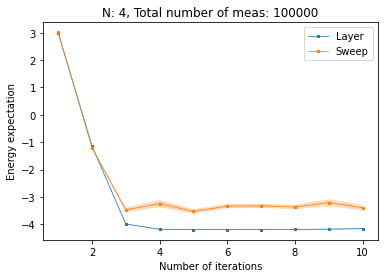

In [14]:
plt.figure()

iteration_list = list(range(1,N_opt+1))

plt.plot(iteration_list, avg_expH, linewidth=0.75, marker='s', markersize=2.5, label='Layer')
plt.plot(iteration_list, avg_expH_sweep, linewidth=0.75, marker='o', markersize=2.5, label='Sweep')
#plt.plot(iteration_list, avg_expH_SDPenhanced_sweep, linewidth=0.75, marker='o', markersize=2.5, label='Sweep-SDP')
#plt.plot(iteration_list, avg_expH_SDPenhanced_sweep_SDPvalue, linewidth=0.75, marker='o', markersize=2.5, label='Sweep-SDP_sol')
plt.fill_between(iteration_list, avg_expH-std_expH, avg_expH+std_expH, alpha=0.3)
plt.fill_between(iteration_list, avg_expH_sweep-std_expH_sweep, avg_expH_sweep+std_expH_sweep, alpha=0.3)
#plt.fill_between(iteration_list, avg_expH_SDPenhanced_sweep-std_expH_SDPenhanced_sweep, avg_expH_SDPenhanced_sweep+std_expH_SDPenhanced_sweep, alpha=0.3)
#plt.fill_between(iteration_list, avg_expH_SDPenhanced_sweep_SDPvalue-std_expH_SDPenhanced_sweep_SDPvalue, avg_expH_SDPenhanced_sweep_SDPvalue+std_expH_SDPenhanced_sweep_SDPvalue, alpha=0.3)

titlename = 'N: ' + str(N) + ', Total number of meas: ' + str(int(N_meas_tol))
plt.title(titlename)
plt.xlabel('Number of iterations')
plt.ylabel('Energy expectation')
plt.legend()

figurename = 'N=4_+state.pdf'
plt.savefig(figurename)

# Show the plot
plt.show()


100%|██████████| 10/10 [02:34<00:00, 15.48s/it]


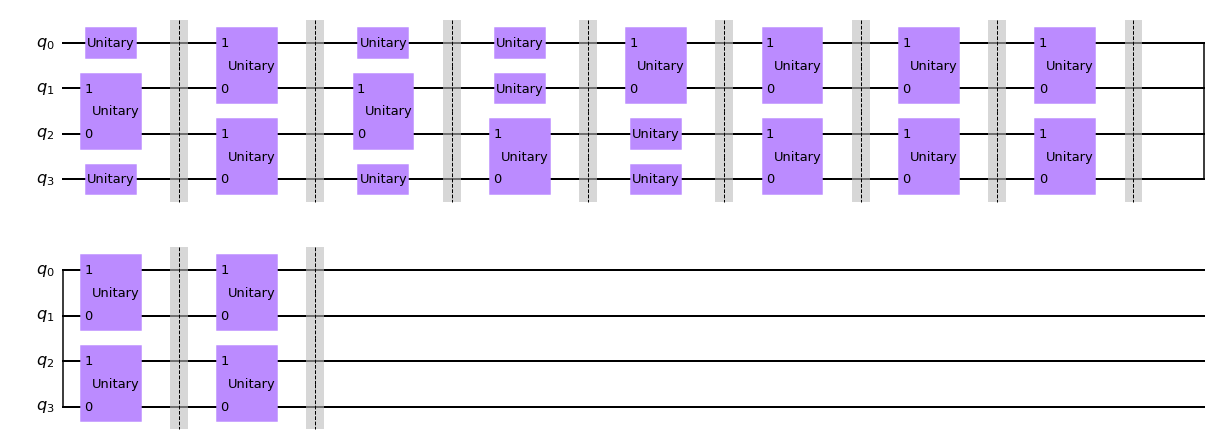

In [8]:
# Calculate the average by tracing dm*state ---- Layer Operators

# Initialize state to + product state
tmp = np.zeros(2**N)
tmp[0] = 1
input_state = DensityMatrix( qiskit_statevec_map( Statevector(tmp), N ) ) # |000> state
# for i in range(N):
#     input_state = input_state.evolve(Hadamard, [i])


expH_dm_layer_iter = []
expH_dm_layer_SDPvalue_iter = {}
expH_dm_layer_SDPvalue_iter['C01'] = [] # expectation value of H minimized by SDP as a function of iterations
expH_dm_layer_SDPvalue_iter['coef'] = []

# Visualize the optimization circuits by Qiskit
qc = QuantumCircuit(N)

for i in tqdm(range(N_opt)):
    meas_dataset = generate_meas_dataset(input_state, N_meas, N)

    # Get the density matrix by tomography and SDP, respectively. Also get the minimized energy by SDP.
    ep = cp.Variable((K, P))
    if model_type=='open':
        K_3body = N-G+1 # Number of 3-body subsystems
    if model_type=='closed':
        K_3body = K # Number of 3-body subsystems
    ep_C1 = cp.Variable((K_3body, 4**G-1))
  
    dm_tilde, dm_hat = SDP_variables_C0(ep, meas_dataset, 
                                        N, M, K, P, 
                                        PauliStrList_part, model_type)

    dm_tilde_C1 = SDP_variables_C1(ep_C1, meas_dataset, 
                                   N, G, K, 
                                   PauliStrList_Gbody, model_type)

    # # Energy with SDP - minimum
    # E_min_C01_value, dm_SDP, coef_min_value = biSection_search_min_C01(higher_bound, threshold, 
    #                                                                         ep, ep_C1, dm_tilde, dm_tilde_C1, 
    #                                                                         H_local_matrix, meas_dataset, 
    #                                                                         N, M, G, K, P,
    #                                                                         model_type
    #                                                                         ) # dm_SDP is the density matrices by SDP

    # expH_dm_layer_SDPvalue_iter['C01'].append(E_min_C01_value)
    # expH_dm_layer_SDPvalue_iter['coef'].append(coef_min_value)


    # Get the expectation value <H>
    exp_H_new = 0
    for H in H_global_list:
        exp, var = exp_var_calculator(meas_dataset, H)
        exp_H_new += exp
    expH_dm_layer_iter.append(exp_H_new)

    # Select the layer_operators
    h_cool, dm_dict = find_h_cool_dm(meas_dataset, h_set, H_global_list, 
                                     dm_hat, N, M, K) # Get the set of h that can induce a cooling unitary
    layer_operators = find_layer_operators(meas_dataset, h_set, h_cool, H_global_list, 
                                           dm_dict, N, M, K)
    
    layer_operators_list = [layer_operators]
    
    for i in range(len(layer_operators_list)):
        
        layer_operators = layer_operators_list[i]
        
        for qubit_index in layer_operators:
            register = list(qubit_index)
            h_best, B, t_opt, decrease = layer_operators[qubit_index]
            h_best_reduced = ''.join(char for char in h_best if char != 'I')

            if (B < 0 and t_opt < 0):
                U = Operator( scipy.linalg.expm( -1j * (t_opt+math.pi/2) * np.array(pauliToMatrix(h_best_reduced)) ) )
            elif (B < 0 and t_opt > 0):
                U = Operator( scipy.linalg.expm( -1j * t_opt * np.array(pauliToMatrix(h_best_reduced)) ) )
            elif (B > 0 and t_opt < 0):
                U = Operator( scipy.linalg.expm( 1j * (-t_opt) * np.array(pauliToMatrix(h_best_reduced)) ) )
            elif (B > 0 and t_opt > 0):
                U = Operator( scipy.linalg.expm( 1j * (-t_opt+math.pi/2) * np.array(pauliToMatrix(h_best_reduced)) ) )
                
            input_state = input_state.evolve(U, register[::-1])
            qc.append(U, register[::-1])

    qc.barrier()

qc.draw('mpl')


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [02:35<00:00, 15.58s/it]


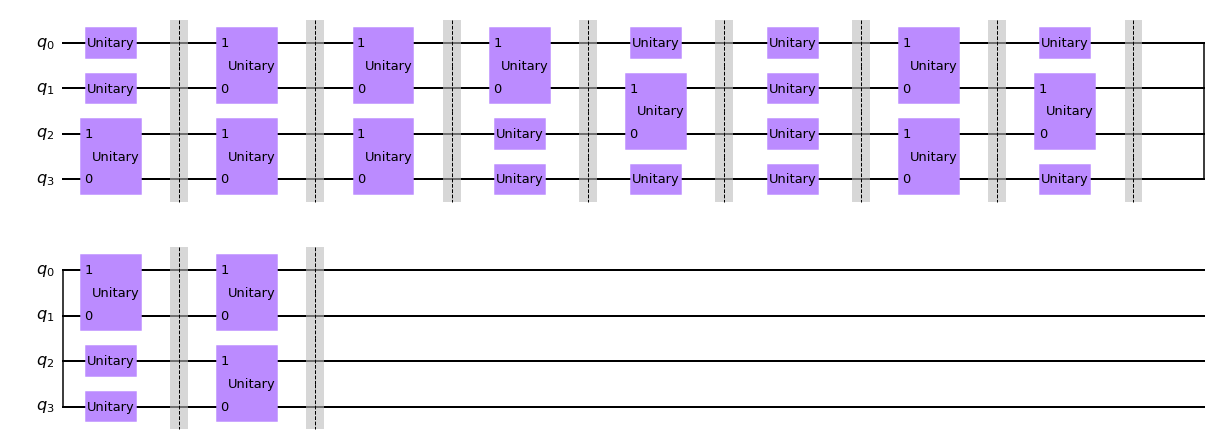

In [9]:
# Calculate the average by tracing dm*state ---- Layer-Sweep Operators

# Initialize state to + product state
tmp = np.zeros(2**N)
tmp[0] = 1
input_state = DensityMatrix( qiskit_statevec_map( Statevector(tmp), N ) ) # |000> state
# for i in range(N):
#     input_state = input_state.evolve(Hadamard, [i])


expH_dm_layer_sweep_iter = []
expH_dm_layer_sweep_SDPvalue_iter = {}
expH_dm_layer_sweep_SDPvalue_iter['C01'] = [] # expectation value of H minimized by SDP as a function of iterations
expH_dm_layer_sweep_SDPvalue_iter['coef'] = []

# Visualize the optimization circuits by Qiskit
qc = QuantumCircuit(N)

for i in tqdm(range(N_opt)):
    meas_dataset = generate_meas_dataset(input_state, N_meas, N)

    # Get the density matrix by tomography and SDP, respectively. Also get the minimized energy by SDP.
    ep = cp.Variable((K, P))
    if model_type=='open':
        K_3body = N-G+1 # Number of 3-body subsystems
    if model_type=='closed':
        K_3body = K # Number of 3-body subsystems
    ep_C1 = cp.Variable((K_3body, 4**G-1))
  
    dm_tilde, dm_hat = SDP_variables_C0(ep, meas_dataset, 
                                        N, M, K, P, 
                                        PauliStrList_part, model_type)

    dm_tilde_C1 = SDP_variables_C1(ep_C1, meas_dataset, 
                                   N, G, K, 
                                   PauliStrList_Gbody, model_type)

    # # Energy with SDP - minimum
    # E_min_C01_value, dm_SDP, coef_min_value = biSection_search_min_C01(higher_bound, threshold, 
    #                                                                         ep, ep_C1, dm_tilde, dm_tilde_C1, 
    #                                                                         H_local_matrix, meas_dataset, 
    #                                                                         N, M, G, K, P,
    #                                                                         model_type
    #                                                                         ) # dm_SDP is the density matrices by SDP

    # expH_dm_layer_sweep_SDPvalue_iter['C01'].append(E_min_C01_value)
    # expH_dm_layer_sweep_SDPvalue_iter['coef'].append(coef_min_value)


    # Get the expectation value <H>
    exp_H_new = 0
    for H in H_global_list:
        exp, var = exp_var_calculator(meas_dataset, H)
        exp_H_new += exp
    expH_dm_layer_sweep_iter.append(exp_H_new)

    # Select the layer_operators
    h_cool, dm_dict = find_h_cool_dm(meas_dataset, h_set, H_global_list, 
                                     dm_hat, N, M, K) # Get the set of h that can induce a cooling unitary
    layer_operators = find_layer_operators(meas_dataset, h_set, h_cool, H_global_list, 
                                           dm_dict, N, M, K)
    
    # Do sweep
    layer_operators_list = [layer_operators]
    num_sweep = 0
    layer_operators_list = find_layer_operators_sweep(meas_dataset, h_set, h_cool, H_global_list, 
                                                      dm_dict, N, M, K,
                                                      layer_operators, num_sweep)
    
    for i in range(len(layer_operators_list)):
        
        layer_operators = layer_operators_list[i]
        
        for qubit_index in layer_operators:
            register = list(qubit_index)
            h_best, B, t_opt, decrease = layer_operators[qubit_index]
            h_best_reduced = ''.join(char for char in h_best if char != 'I')

            if (B < 0 and t_opt < 0):
                U = Operator( scipy.linalg.expm( -1j * (t_opt+math.pi/2) * np.array(pauliToMatrix(h_best_reduced)) ) )
            elif (B < 0 and t_opt > 0):
                U = Operator( scipy.linalg.expm( -1j * t_opt * np.array(pauliToMatrix(h_best_reduced)) ) )
            elif (B > 0 and t_opt < 0):
                U = Operator( scipy.linalg.expm( 1j * (-t_opt) * np.array(pauliToMatrix(h_best_reduced)) ) )
            elif (B > 0 and t_opt > 0):
                U = Operator( scipy.linalg.expm( 1j * (-t_opt+math.pi/2) * np.array(pauliToMatrix(h_best_reduced)) ) )
                
            input_state = input_state.evolve(U, register[::-1])
            qc.append(U, register[::-1])

    qc.barrier()

qc.draw('mpl')


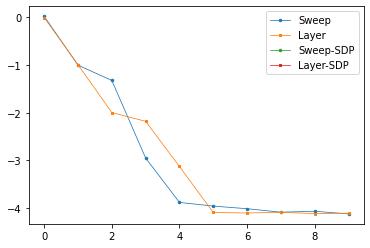

In [11]:
plt.plot(expH_dm_layer_sweep_iter, linewidth=0.75, marker='o', markersize=2.5, label='Sweep')
plt.plot(expH_dm_layer_iter, linewidth=0.75, marker='s', markersize=2.5, label='Layer')
plt.plot(expH_dm_layer_sweep_SDPvalue_iter['C01'], linewidth=0.75, marker='o', markersize=2.5, label='Sweep-SDP')
plt.plot(expH_dm_layer_SDPvalue_iter['C01'], linewidth=0.75, marker='s', markersize=2.5, label='Layer-SDP')
plt.legend()

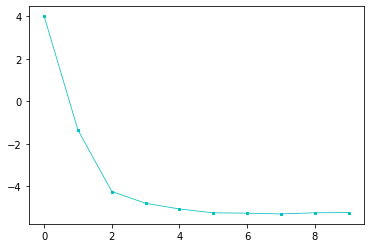

In [18]:
plt.plot(expH_dm_layer_iter, linewidth=0.75, color='c', marker='s', markersize=2.5, label='Layer')


In [ ]:
# Calculate the average by tracing dm*state ---- Single Operators

# Initialize state to + product state
tmp = np.zeros(2**N)
tmp[0] = 1
input_state = DensityMatrix( qiskit_statevec_map( Statevector(tmp), N ) ) # |000> state
for i in range(N):
    input_state = input_state.evolve(Hadamard, [i])
    

expH_dm_single_iter = []
expH_dm_single_SDPvalue_iter = {}
expH_dm_single_SDPvalue_iter['C01'] = [] # expectation value of H minimized by SDP as a function of iterations
expH_dm_single_SDPvalue_iter['coef'] = []

# Visualize the optimization circuits by Qiskit
qc = QuantumCircuit(N)

for i in tqdm(range(N_opt)):
    meas_dataset = generate_meas_dataset(input_state, N_meas, N)

    # Get the density matrix by tomography and SDP, respectively. Also get the minimized energy by SDP.
    ep = cp.Variable((K, P))
    if model_type=='open':
        K_3body = N-G+1 # Number of 3-body subsystems
    if model_type=='closed':
        K_3body = K # Number of 3-body subsystems
    ep_C1 = cp.Variable((K_3body, 4**G-1))
  
    dm_tilde, dm_hat = SDP_variables_C0(ep, meas_dataset, 
                                        N, M, K, P, 
                                        PauliStrList_part, model_type)

    dm_tilde_C1 = SDP_variables_C1(ep_C1, meas_dataset, 
                                   N, G, K, 
                                   PauliStrList_Gbody, model_type)

    # Energy with SDP - minimum
    E_min_C01_value, dm_SDP, coef_min_value = biSection_search_min_C01(higher_bound, threshold, 
                                                                            ep, ep_C1, dm_tilde, dm_tilde_C1, 
                                                                            H_local_matrix, meas_dataset, 
                                                                            N, M, G, K, P,
                                                                            model_type
                                                                            ) # dm_SDP is the density matrices by SDP

    expH_dm_single_SDPvalue_iter['C01'].append(E_min_C01_value)
    expH_dm_single_SDPvalue_iter['coef'].append(coef_min_value)


    # Get the expectation value <H>
    exp_H_new = 0
    for H in H_global_list:
        exp, var = exp_var_calculator(meas_dataset, H)
        exp_H_new += exp
    expH_dm_single_iter.append(exp_H_new)

    # Select the best h (the one such that e^(-iht) gives the most decrease in <H>)
    h_cool, dm_dict = find_h_cool_dm(meas_dataset, h_set, H_global_list, dm_hat,
                                     N, M, K) # Get the set of h that can induce a cooling unitary
    h_best, B, t_opt, decrease = max(h_cool, key=lambda x: abs(x[3])) 
    
    # Get the Qiskit circuit of e^(-iht)
    circ_meas = QuantumCircuit(N) 
    h_best_reduced = ''.join(char for char in h_best if char != 'I')
    register = [i for i, char in enumerate(h_best) if char != 'I']
    if (B < 0 and t_opt < 0):
        U = Operator( scipy.linalg.expm( -1j * (t_opt+math.pi/2) * np.array(pauliToMatrix(h_best_reduced)) ) )
    elif (B < 0 and t_opt > 0):
        U = Operator( scipy.linalg.expm( -1j * t_opt * np.array(pauliToMatrix(h_best_reduced)) ) )
    elif (B > 0 and t_opt < 0):
        U = Operator( scipy.linalg.expm( 1j * (-t_opt) * np.array(pauliToMatrix(h_best_reduced)) ) )
    elif (B > 0 and t_opt > 0):
        U = Operator( scipy.linalg.expm( 1j * (-t_opt+math.pi/2) * np.array(pauliToMatrix(h_best_reduced)) ) )

    tmp = input_state
    input_state = tmp.evolve(U, register[::-1])
    qc.append(U, register[::-1])

    qc.barrier()

qc.draw('mpl')



In [ ]:
# Calculate the average by tracing dm*state with SDP-enhanced tomography ---- Layer Operators

# Initialize state to + product state
tmp = np.zeros(2**N)
tmp[0] = 1
input_state = DensityMatrix( qiskit_statevec_map( Statevector(tmp), N ) ) # |000> state
for i in range(N):
    input_state = input_state.evolve(Hadamard, [i])

expH_dmsdp_layer_iter = []
expH_dmsdp_layer_SDPvalue_iter = {}
expH_dmsdp_layer_SDPvalue_iter['C01'] = [] # expectation value of H minimized by SDP as a function of iterations
expH_dmsdp_layer_SDPvalue_iter['coef'] = []

# Visualize the optimization circuits by Qiskit
qc = QuantumCircuit(N)

for i in tqdm(range(N_opt)):
    meas_dataset = generate_meas_dataset(input_state, N_meas, N)

    # Get the density matrix by tomography and SDP, respectively. Also get the minimized energy by SDP.
    ep = cp.Variable((K, P))
    if model_type=='open':
        K_3body = N-G+1 # Number of 3-body subsystems
    if model_type=='closed':
        K_3body = K # Number of 3-body subsystems
    ep_C1 = cp.Variable((K_3body, 4**G-1))
  
    dm_tilde, dm_hat = SDP_variables_C0(ep, meas_dataset, 
                                        N, M, K, P, 
                                        PauliStrList_part, model_type)

    dm_tilde_C1 = SDP_variables_C1(ep_C1, meas_dataset, 
                                   N, G, K, 
                                   PauliStrList_Gbody, model_type)

    # Energy with SDP - minimum
    E_min_C01_value, dm_SDP, coef_min_value = biSection_search_min_C01(higher_bound, threshold, 
                                                                            ep, ep_C1, dm_tilde, dm_tilde_C1, 
                                                                            H_local_matrix, meas_dataset, 
                                                                            N, M, G, K, P,
                                                                            model_type
                                                                            ) # dm_SDP is the density matrices by SDP

    expH_dmsdp_layer_SDPvalue_iter['C01'].append(E_min_C01_value)
    expH_dmsdp_layer_SDPvalue_iter['coef'].append(coef_min_value)


    # Get the expectation value <H>
    exp_H_new = 0
    for H in H_global_list:
        exp, var = exp_var_calculator(meas_dataset, H)
        exp_H_new += exp
    expH_dmsdp_layer_iter.append(exp_H_new)

    # Select the layer_operators
    h_cool, dm_dict = find_h_cool_dm(meas_dataset, h_set, H_global_list, 
                                     dm_SDP, N, M, K) # Get the set of h that can induce a cooling unitary
    layer_operators = find_layer_operators(meas_dataset, h_set, h_cool, H_global_list, 
                                           dm_dict, N, M, K)
    
    for qubit_index in layer_operators:
        register = list(qubit_index)
        h_best, B, t_opt, decrease = layer_operators[qubit_index]
        h_best_reduced = ''.join(char for char in h_best if char != 'I')

        if (B < 0 and t_opt < 0):
            U = Operator( scipy.linalg.expm( -1j * (t_opt+math.pi/2) * np.array(pauliToMatrix(h_best_reduced)) ) )
        elif (B < 0 and t_opt > 0):
            U = Operator( scipy.linalg.expm( -1j * t_opt * np.array(pauliToMatrix(h_best_reduced)) ) )
        elif (B > 0 and t_opt < 0):
            U = Operator( scipy.linalg.expm( 1j * (-t_opt) * np.array(pauliToMatrix(h_best_reduced)) ) )
        elif (B > 0 and t_opt > 0):
            U = Operator( scipy.linalg.expm( 1j * (-t_opt+math.pi/2) * np.array(pauliToMatrix(h_best_reduced)) ) )

        input_state = input_state.evolve(U, register[::-1])
        qc.append(U, register[::-1])

    qc.barrier()

qc.draw('mpl')


In [ ]:
plt.figure(figsize=(8, 4.5))

plt.plot(expH_dm_single_iter, linewidth=0.75, color='g', marker='s', markersize=2.5, label='Single')
plt.plot(expH_dm_single_SDPvalue_iter['C01'], linewidth=0.75, color='g', marker='o', markersize=2.5, label='Single+SDP.min')
plt.plot(expH_dm_layer_iter, linewidth=0.75, color='c', marker='s', markersize=2.5, label='Layer')
plt.plot(expH_dm_layer_SDPvalue_iter['C01'], linewidth=0.75, color='c', marker='o', markersize=2.5, label='Layer+SDP.min')
plt.plot(expH_dmsdp_layer_iter, linewidth=0.75, color='y', marker='s', markersize=2.5, label='SDP-enhenced-Tomograph')
plt.plot(expH_dmsdp_layer_SDPvalue_iter['C01'], linewidth=0.75, color='y', marker='o', markersize=2.5, label='SDP-enhenced-Tomograph+SDP.min')


plt.axhline(y = ground_state_energy, color='r', linestyle='-', linewidth=1.25, label='GS energy')

titlename = 'N: ' + str(N) + ', Total number of meas: ' + str(int(N_meas_tol))
plt.title(titlename)
plt.xlabel('Number of interation')
plt.ylabel('Energy expectation value')
plt.legend()

figurename = model_type + '_N' + str(N) + '_opt_+' + '.pdf'
figurepath = f'figures/{figurename}'
#plt.savefig(figurepath, bbox_inches='tight')
plt.show()

In [ ]:
# Calculate the average by tracing dm*state with SDP-enhanced tomography

# Initialize states 
tmp = np.zeros(2**N)
tmp[0] = 1
input_state = DensityMatrix( qiskit_statevec_map( Statevector(tmp), N ) ) # |000> state

expectation_dmsdp_H_iter = []
expectation_dmsdp_SDP_iter = {}
expectation_dmsdp_SDP_iter['C01'] = [] # expectation value of H minimized by SDP as a function of iterations
expectation_dmsdp_SDP_iter['coef'] = []

for i in tqdm(range(N_opt)):
    meas_dataset = generate_meas_dataset(input_state, N_meas, N)

    # Get the density matrix by tomography and SDP, respectively. Also get the minimized energy by SDP.
    ep = cp.Variable((K, P))
    if model_type=='open':
        K_3body = N-G+1 # Number of 3-body subsystems
    if model_type=='closed':
        K_3body = K # Number of 3-body subsystems
    ep_C1 = cp.Variable((K_3body, 4**G-1))
  
    dm_tilde, dm_hat = SDP_variables_C0(ep, meas_dataset, 
                                        N, M, K, P, 
                                        PauliStrList_part, model_type)

    dm_tilde_C1 = SDP_variables_C1(ep_C1, meas_dataset, 
                                   N, G, K, 
                                   PauliStrList_Gbody, model_type)

    # Energy with SDP - minimum
    E_min_C01_value, dm_SDP, coef_min_value = biSection_search_min_C01(higher_bound, threshold, 
                                                                            ep, ep_C1, dm_tilde, dm_tilde_C1, 
                                                                            H_local_matrix, meas_dataset, 
                                                                            N, M, G, K, P,
                                                                            model_type
                                                                            ) # dm_SDP is the density matrices by SDP

    expectation_dmsdp_SDP_iter['C01'].append(E_min_C01_value)
    expectation_dmsdp_SDP_iter['coef'].append(coef_min_value)


    # Get the expectation value <H>
    exp_H_new = 0
    for H in H_global_list:
        exp, var = exp_var_calculator(meas_dataset, H)
        exp_H_new += exp
    expectation_dmsdp_H_iter.append(exp_H_new)

    # Select the best h (the one such that e^(-iht) gives the most decrease in <H>)
    h_cool = find_h_cool_dm(meas_dataset, h_set, H_global_list, dm_SDP) # Get the set of h that can induce a cooling unitary
    h_best, B, t_opt, decrease = max(h_cool, key=lambda x: abs(x[3])) 
    
    # Get the Qiskit circuit of e^(-iht)
    circ_meas = QuantumCircuit(N) 
    if (B < 0 and t_opt < 0):
        U = Operator( scipy.linalg.expm( -1j * (t_opt+math.pi/2) * np.array(pauliToMatrix(h_best)) ) )
    elif (B < 0 and t_opt > 0):
        U = Operator( scipy.linalg.expm( -1j * t_opt * np.array(pauliToMatrix(h_best)) ) )
    elif (B > 0 and t_opt < 0):
        U = Operator( scipy.linalg.expm( 1j * (-t_opt) * np.array(pauliToMatrix(h_best)) ) )
    elif (B > 0 and t_opt > 0):
        U = Operator( scipy.linalg.expm( 1j * (-t_opt+math.pi/2) * np.array(pauliToMatrix(h_best)) ) )

    register = list(range(N))
    tmp = input_state
    input_state = tmp.evolve(U, register[::-1])



In [ ]:
# Calculate the average by adding Paulis

# Initialize states 
tmp = np.zeros(2**N)
tmp[0] = 1
input_state = DensityMatrix( qiskit_statevec_map( Statevector(tmp), N ) ) # |000> state

# expectation value of H as a function of iterations
expectation_H_iter = []
expectation_SDP_iter = {}
expectation_SDP_iter['C01'] = [] # expectation value of H minimized by SDP as a function of iterations
expectation_SDP_iter['coef'] = []

for i in tqdm(range(N_opt)):
    meas_dataset = generate_meas_dataset(input_state, N_meas, N)

    # Get the density matrix by tomography and SDP, respectively. Also get the minimized energy by SDP.
    ep = cp.Variable((K, P))
    if model_type=='open':
        K_3body = N-G+1 # Number of 3-body subsystems
    if model_type=='closed':
        K_3body = K # Number of 3-body subsystems
    ep_C1 = cp.Variable((K_3body, 4**G-1))
  
    dm_tilde, dm_hat = SDP_variables_C0(ep, meas_dataset, 
                                        N, M, K, P, 
                                        PauliStrList_part, model_type) # dm_hat is the density matrices by tomography
    dm_tilde_C1 = SDP_variables_C1(ep_C1, meas_dataset, 
                                   N, G, K, 
                                   PauliStrList_Gbody, model_type)

    # Energy with SDP - minimum
    E_min_C01_value, dm_SDP, coef_min_value = biSection_search_min_C01(higher_bound, threshold, 
                                                                            ep, ep_C1, dm_tilde, dm_tilde_C1, 
                                                                            H_local_matrix, meas_dataset, 
                                                                            N, M, G, K, P,
                                                                            model_type
                                                                            ) # dm_SDP is the density matrices by SDP

    expectation_SDP_iter['C01'].append(E_min_C01_value)
    expectation_SDP_iter['coef'].append(coef_min_value)


    # Get the expectation value <H>
    exp_H_new = 0
    for H in H_global_list:
        exp, var = exp_var_calculator(meas_dataset, H)
        exp_H_new += exp
    expectation_H_iter.append(exp_H_new)

    # Select the best h (the one such that e^(-iht) gives the most decrease in <H>)
    h_cool = find_h_cool(meas_dataset, h_set, H_global_list) # Get the set of h that can induce a cooling unitary
    h_best, B, t_opt, decrease = max(h_cool, key=lambda x: abs(x[3])) 
    
    # Get the Qiskit circuit of e^(-iht)
    circ_meas = QuantumCircuit(N) 
    if (B < 0 and t_opt < 0):
        U = Operator( scipy.linalg.expm( -1j * (t_opt+math.pi/2) * np.array(pauliToMatrix(h_best)) ) )
    elif (B < 0 and t_opt > 0):
        U = Operator( scipy.linalg.expm( -1j * t_opt * np.array(pauliToMatrix(h_best)) ) )
    elif (B > 0 and t_opt < 0):
        U = Operator( scipy.linalg.expm( 1j * (-t_opt) * np.array(pauliToMatrix(h_best)) ) )
    elif (B > 0 and t_opt > 0):
        U = Operator( scipy.linalg.expm( 1j * (-t_opt+math.pi/2) * np.array(pauliToMatrix(h_best)) ) )

    register = list(range(N))
    tmp = input_state
    input_state = tmp.evolve(U, register[::-1])

In [ ]:
plt.figure(figsize=(8, 4.5))

plt.plot(expectation_H_iter, linewidth=0.75, marker='s', markersize=2.5, label='')
plt.plot(expectation_SDP_iter['C01'], linewidth=0.75, marker='s', markersize=2.5, label='SDP')
plt.plot(expectation_dm_H_iter, linewidth=0.75, marker='s', markersize=2.5, label='Tomograph')
plt.plot(expectation_dm_SDP_iter['C01'], linewidth=0.75, marker='s', markersize=2.5, label='SDP')

plt.axhline(y = ground_state_energy, color='r', linestyle='-', linewidth=1.25, label='GS energy')

titlename = 'N: ' + str(N) + ', Total number of meas: ' + str(int(N_meas_tol))
plt.title(titlename)
plt.xlabel('Number of iteration')
plt.ylabel('Energy expectation value')
plt.legend()

figurename = model_type + '_N' + str(N) + '_opt' + '.pdf'
figurepath = f'figures/{figurename}'
#plt.savefig(figurepath, bbox_inches='tight')
plt.show()

In [ ]:
for k in range(K):  # K: number of subsystems
    index = list(range(k, k + M, 1))  # [k, k+1, ...]
    print(index)

In [ ]:
def SDP_variables_C0000(ep:cp.expressions.variable.Variable, 
                     measurement_dataset:Dict[str,List[str]], 
                     N:int, M:int, K:int, P:int, 
                     PauliStrList_part:List[str],
                     model_type:str) -> cp.atoms.affine.add_expr.AddExpression:
    '''Define SDP variables'''
    dm = []

    if model_type=='open':
        for k in range(K):  # K: number of subsystems
            index = list(range(k, k + M, 1))  # [k, k+1, ...]
            dm.append(np.array(q_tomography_dm(index, measurement_dataset, N)))
        dm_hat = dm.copy()
        dm_tilde = dm.copy()
        for k in range(K):
            for p in range(P):
                dm_tilde[k] = dm_tilde[k] + cp.multiply(ep[k, p], np.array(pauliToMatrix(PauliStrList_part[p])))
    
    if model_type=='closed':
        for k in range(K):  # K: number of subsystems
            index = [(k + i) % K for i in range(M)]  # [k, k+1, ...]
            dm.append(np.array(q_tomography_dm(index, measurement_dataset, N)))
        dm_hat = dm.copy()
        dm_tilde = dm.copy()
        for k in range(K):
            for p in range(P):
                dm_tilde[k] = dm_tilde[k] + cp.multiply(ep[k, p], np.array(pauliToMatrix(PauliStrList_part[p])))
    
    return dm_tilde, dm_hat

In [ ]:
meas_dataset = generate_meas_dataset(input_state, 1000, N)

dm_tilde, dm_hat = SDP_variables_C0000(ep, meas_dataset, N, M, K, P, PauliStrList_part, model_type)

# Energy with SDP - minimum
energy_C01, dm_SDP, coef = biSection_search_min_C01(higher_bound, threshold, 
                                                ep, ep_C1, dm_tilde, dm_tilde_C1, 
                                                                        H_local_matrix, meas_dataset, 
                                                                        N, M, G, K, P,
                                                                        model_type
                                                                        )

dm_hat

In [ ]:
dm_tilde

In [ ]:
q_tomography_dm(qubit_index=[0,1], measurement_dataset=meas_dataset, N=N)

In [ ]:
plt.figure(figsize=(8, 4.5))

plt.plot(exp_H_list, linewidth=0.75, marker='s', markersize=2.5, label='Cooling')
plt.plot(exp_SDP_list['C01'], linewidth=0.75, marker='s', markersize=2.5, label='SDP')
plt.axhline(y = ground_state_energy, color='r', linestyle='-', linewidth=1.25, label='GS energy')

titlename = 'N: ' + str(N) + ', Total number of meas: ' + str(int(N_meas_tol))
plt.title(titlename)
plt.xlabel('Number of interation')
plt.ylabel('Energy expectation value')
plt.legend()

figurename = model_type + '_N' + str(N) + '_opt' + '.pdf'
figurepath = f'figures/{figurename}'
#plt.savefig(figurepath, bbox_inches='tight')
plt.show()

In [ ]:
# Initialize states 
tmp = np.zeros(2**N)
tmp[0] = 1
input_state = DensityMatrix( qiskit_statevec_map( Statevector(tmp), N ) ) # |000> state
meas_dataset = generate_meas_dataset(input_state, N_meas, N)

# Get the density matrix by tomography and SDP, respectively. Also get the minimized energy by SDP.
ep = cp.Variable((K, P))
if model_type=='open':
    K_3body = N-G+1 # Number of 3-body subsystems
if model_type=='closed':
    K_3body = K # Number of 3-body subsystems
ep_C1 = cp.Variable((K_3body, 4**G-1))

dm_tilde, dm_hat = SDP_variables_C0(ep, meas_dataset, 
                                    N, M, K, P, 
                                    PauliStrList_part, model_type)

dm_tilde_C1 = SDP_variables_C1(ep_C1, meas_dataset, 
                                N, G, K, 
                                PauliStrList_Gbody, model_type)

h_cool, dm_dict = find_h_cool_dm(meas_dataset, h_set, H_global_list, 
                                 dm_hat, N, M, K) # Get the set of h that can induce a cooling unitary
find_layer_operators(meas_dataset, h_set, h_cool, H_global_list, 
                         dm_dict, N, M, K)
